In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys

from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter

plt.style.use("~/evanstyle.mplstyle")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import Dataset
import AnalysisTools

In [2]:
#toproot = "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/"
toproot = "../../data/"
topdirs = {5:toproot+"Run5/", 6:toproot+"Run6/", 7:toproot+"Run7/", 8:toproot+"Run8/", 9:toproot+"Run9/"}
configs = {5:"../configs/run5_config.yaml", 6:"../configs/run6_config.yaml", 7:"../configs/run7_config.yaml", 8:"../configs/run8_config.yaml", 9:"../configs/run9_config.yaml"}
titles = {5:"SS uncoated", 6:"Refill of SS uncoated", 7:"MgF2 (50nm)", 8:"Pt (50nm)", 9:"MgF2 (20nm)"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    if(n == 6 or n == 5):continue
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])



/Users/ejangelico/Documents/Stanford/GasBreakdownChamber/code/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:132: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


In [3]:
#load data into mem if you want
for n, ana in anas.items():
    if(n == 6 or n == 5): continue
    ana.load_dataframe()

# Developing better HV interpolation
### The present dataset.py code doesn't do a great job of analyzing the ramp.txt and g_events.txt files to the degree that we want. The biggest drawback is that only voltage datapoints are logged when the glassman control loop is running. So interpreting what happens in the gaps can be wrong.

In [25]:
ana = anas[9]
ana.load_hv_textfiles()
ana.correct_hv_data()

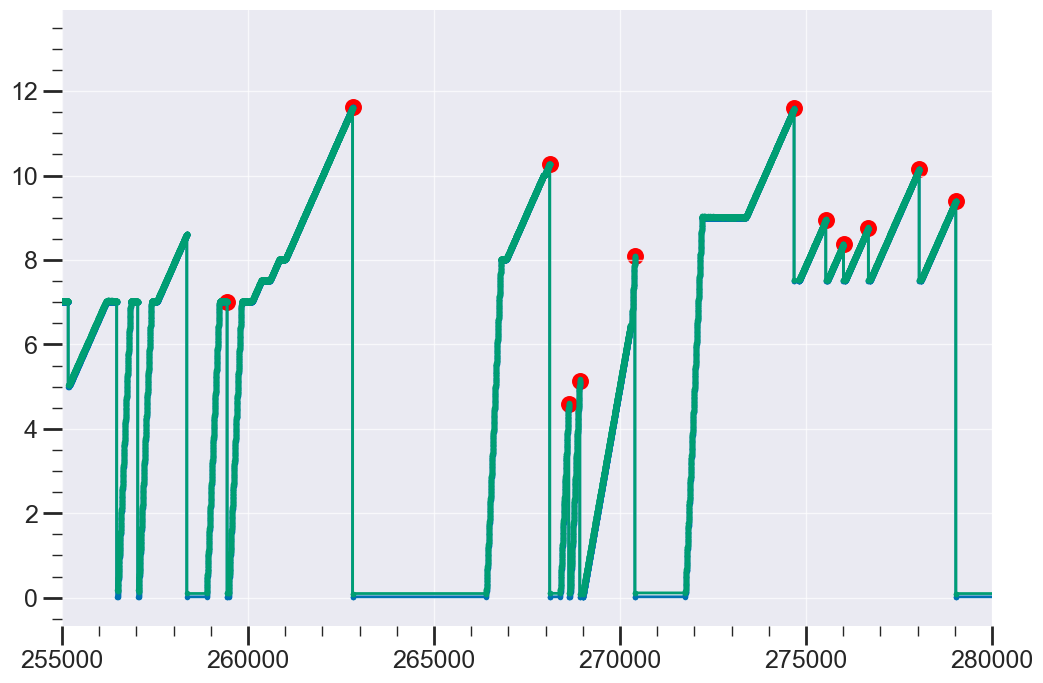

In [66]:
rd = ana.ramp_data
rd = rd.sort_values("t")
ge = ana.g_event_data

ge_ts = ge["t"] - np.min(rd["t"])
rd_ts = rd["t"] - np.min(rd["t"])


fig, ax = plt.subplots()
ax.plot(rd_ts, rd["v_app"], 'o-')
ax.plot(rd_ts, rd["v_mon"], 'o-')
ax.scatter(ge_ts, ge["v_app"], color='red', s=500)
ax.set_xlim([255000, 280000])
#ax.set_ylim([0, 0.15])
plt.show()

In [68]:
ana.create_time_duration_map()

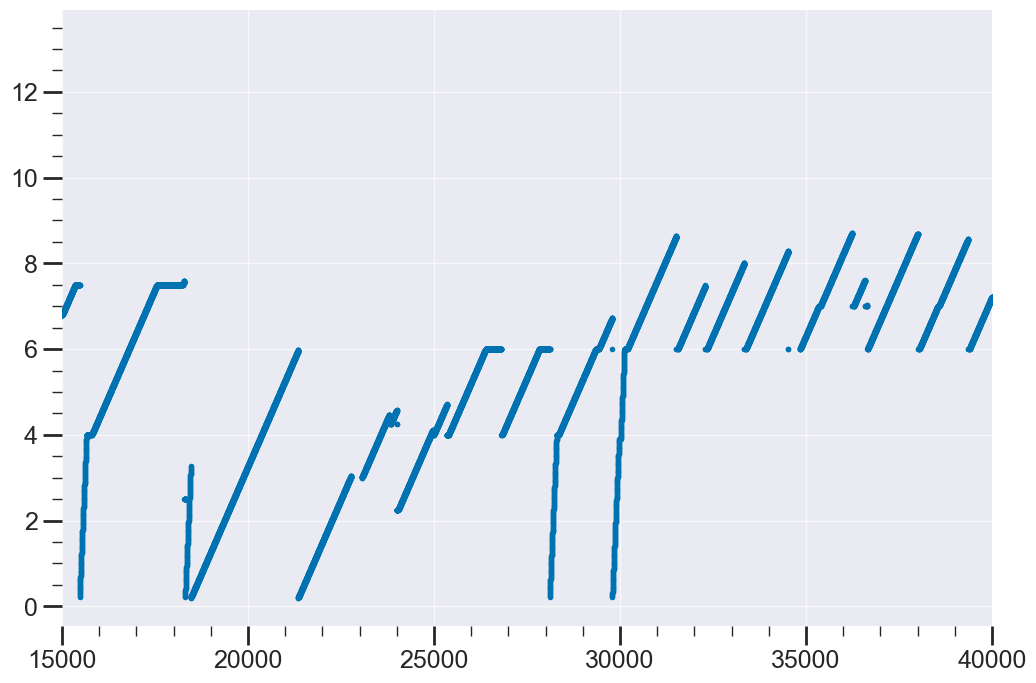

In [71]:
ts = ana.time_duration_map["t"]
durs = ana.time_duration_map["dur"]
vs = ana.time_duration_map["v"]
fig, ax = plt.subplots()
ax.plot(durs, vs, 'o')
ax.set_xlim([15000, 40000])
plt.show()

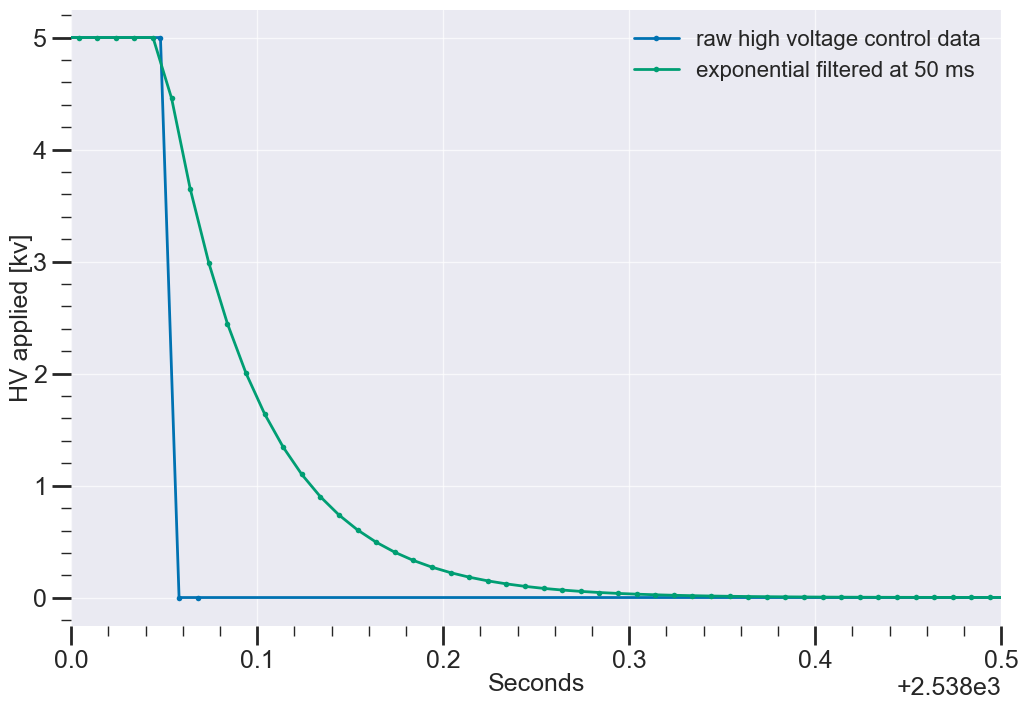

In [17]:
from scipy.interpolate import interp1d
rd = ana.ramp_data
rd = rd.sort_values("t")
ge = ana.g_event_data
ge = ge.sort_values("t")

ge_ts = ge["t"] - np.min(rd["t"])
rd_ts = rd["t"] - np.min(rd["t"])

bd = [2400, 2450]
x_bd = np.array(rd_ts[bd[0]:bd[1]])
y_bd = np.array(rd["v_app"])[bd[0]:bd[1]]

fine_x = np.arange(x_bd[0], x_bd[-1], 0.01)
s = interp1d(x_bd, y_bd)
fine_y = s(fine_x)

filty, filtx = ana.exponential_filter(fine_x, fine_y, 0.05)

fig, ax = plt.subplots()
ax.plot(x_bd, y_bd, 'o-', label="raw high voltage control data")
ax.plot(filtx, filty, 'o-', label="exponential filtered at 50 ms")

ax.legend()
ax.set_xlim([2538, 2538.5])
ax.set_xlabel("Seconds")
ax.set_ylabel("HV applied [kv]")
plt.show()

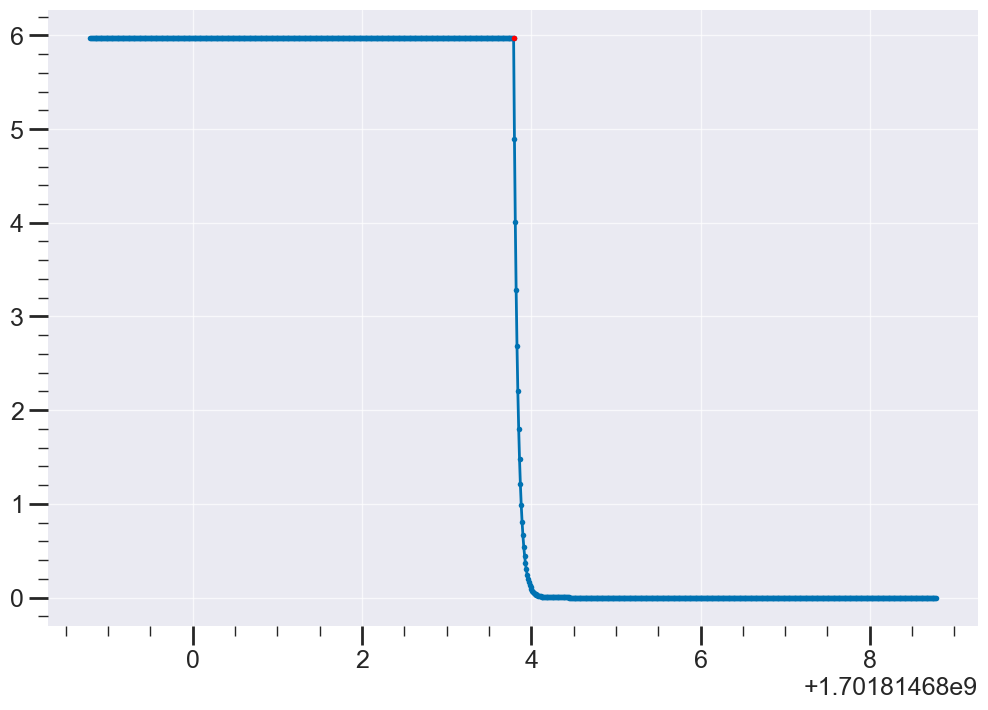

In [26]:
gedf = ana.g_event_data
ge_ev = gedf.sample()
bd = [ge_ev["t"].iloc[0] - 5, ge_ev["t"].iloc[0] + 5]
ts = np.arange(bd[0], bd[1], 0.01)
hv = [ana.get_hv_at_time(t) for t in ts]
fig, ax = plt.subplots()
ax.plot(ts, hv, 'o-')
ax.plot(ge_ev["t"], ge_ev["v_app"], 'o', color='red')
plt.show()



In [23]:
print(ge_ev["t"].iloc[0])

1701736158.693
